In [ ]:
import torch
import pandas as pd
import numpy as np
import os
from datetime import datetime
import matplotlib.pyplot as plt

print(torch.cuda.is_available())
# pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

device = "cuda" if torch.cuda.is_available() else "cpu"

True


In [ ]:


# Use only 1 GPU if available
if torch.cuda.is_available():
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"


# import matplotlib.pyplot as plt
from chronos import BaseChronosPipeline, Chronos2Pipeline

# Load the Chronos-2 pipeline
# GPU recommended for faster inference, but CPU is also supported using device_map="cpu"

pipeline: Chronos2Pipeline = BaseChronosPipeline.from_pretrained("amazon/chronos-2", device_map=device)

c:\Users\aleky\Desktop\uni magistrale\Deep Natural language processing\Project\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def parse_ims_timestamp(timestamp_str):
    """
    Convert IMS timestamp format (YYYY.MM.DD.HH.MM.SS) to datetime object.
    
    Args:
        timestamp_str: String in format "2004.02.12.10.32.39"
    
    Returns:
        datetime object
    """
    return datetime.strptime(timestamp_str, "%Y.%m.%d.%H.%M.%S")



In [4]:
def process_ims_file(filepath, column=0):
    """
    Legge un file IMS  e estrae le feature.
    ogni colonna è un canale/cuscinetto.
    Le feature estratte sono:
        1. RMS (Energia)
        2. Kurtosis (Impulsività)
        3. peak amplitude
    """
    # Leggiamo il file (tab separated)
    df = pd.read_csv(filepath, sep='\t', header=None)
    
    # Prendiamo il cuscinetto specificato dalla colonna
    bearing_data = df.values 
    
    # 1. RMS (Energia) 
    rms = np.sqrt(np.mean(bearing_data**2, axis=0))
    
    # 2. Kurtosis (Impulsività) 
    mean = np.mean(bearing_data, axis=0)
    std = np.std(bearing_data, axis=0)  
    kurtosis = np.mean(((bearing_data - mean) / std) ** 4, axis=0)
    
    
    return rms, kurtosis, np.max(np.abs(bearing_data),axis=0)


    

In [5]:
data_path = "IMS/IMS/2nd_test"
records = []

for root, dirs, files in os.walk(data_path):
    for file in sorted(files):
        rms, kurtosis, peak_amplitude = process_ims_file(os.path.join(root, file))
        records.append({"timestamp": parse_ims_timestamp(file), 
                        "rms1": rms[0], "rms2": rms[1], "rms3": rms[2], "rms4": rms[3],
                        "kurtosis1": kurtosis[0], "kurtosis2": kurtosis[1], "kurtosis3": kurtosis[2], "kurtosis4": kurtosis[3],
                        "peak_amplitude1": peak_amplitude[0], "peak_amplitude2": peak_amplitude[1], "peak_amplitude3": peak_amplitude[2], "peak_amplitude4": peak_amplitude[3]})

data = pd.DataFrame(records)
data.head()


,timestamp,rms1,rms2,rms3,rms4,kurtosis1,kurtosis2,kurtosis3,kurtosis4,peak_amplitude1,peak_amplitude2,peak_amplitude3,peak_amplitude4
0,2004-02-12 10:32:39,0.074179,0.090944,0.109404,0.054103,3.628763,3.506801,6.213075,3.065959,0.454,0.513,1.023,0.264
1,2004-02-12 10:42:39,0.075382,0.093419,0.109817,0.056101,3.648291,3.253014,4.395250,3.107539,0.388,0.481,0.752,0.249
2,2004-02-12 10:52:39,0.076230,0.093718,0.109861,0.056145,3.513475,3.310789,5.639948,3.257236,0.503,0.503,0.933,0.354
3,2004-02-12 11:02:39,0.078724,0.092947,0.110667,0.056807,4.157953,3.235341,5.682779,3.806190,0.608,0.569,1.016,0.525
4,2004-02-12 11:12:39,0.078474,0.095348,0.107506,0.056841,3.603177,3.226309,4.578395,3.138954,0.391,0.486,0.771,0.244


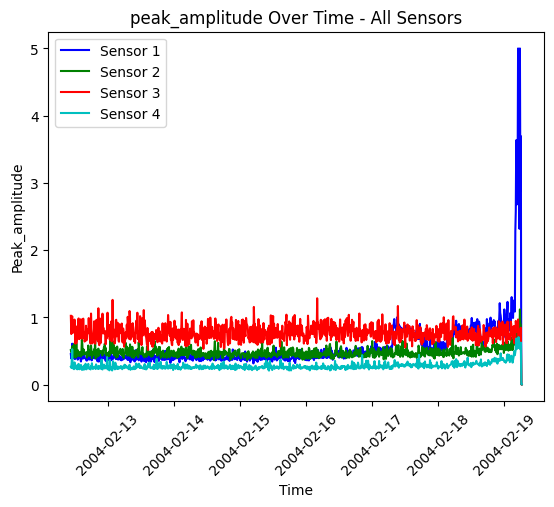

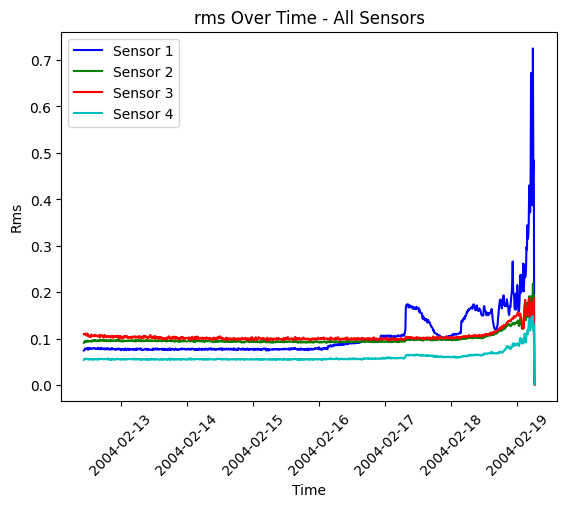

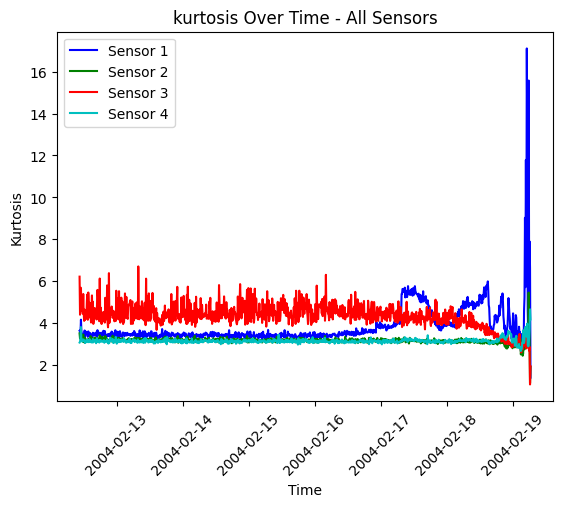

In [6]:
def plot_all_features(data):
    """
    Plot each feature for all 4 sensors over time
    Each row contains arrays of 4 values (one per sensor)
    """
    features = ['peak_amplitude', 'rms', 'kurtosis']
    colors = ['b', 'g', 'r', 'c']
    for feature in features:
        plt.title(f'{feature} Over Time - All Sensors')    
        # Create a figure with 4 subplots (one per sensor)
        for col in [col for col in data.columns if col.startswith(feature)] :
           plt.plot(data['timestamp'], data[col], label=f'Sensor {col[-1]}', color=colors[int(col[-1])-1], )
           plt.xlabel('Time')
           plt.ylabel(feature.capitalize())
           plt.xticks(rotation=45)
        plt.legend()
        plt.show()
              
# Run the plotting function
plot_all_features(data)

From the visualizations is clear that the Failure happens in the first braring (item_id=0).
Note very near to the breakpoint the effect on the other bearing are also visible.


In [7]:
PRED_LEN = 100
INITIAL_DATA_POINTS = 100
#fitto il primo 30% dei dati
 
train =  data[:data.shape[0]*30//100]
test = data[data.shape[0]*30//100:]

train.shape, test.shape 

((295, 13), (689, 13))

In [8]:
def compute_mahalanobis(df, percentage_of_data= 30):
    features = ['rms', 'kurtosis', 'peak_amplitude']
    data = df[:df.shape[0]*percentage_of_data//100]
    
    mean = data[features].mean().values
    cov = np.cov(data[features].values, rowvar=False)
    inv_covmat = np.linalg.inv(cov)
    
    def mahalanobis_distance(row):
        x = row[features].values
        diff = x - mean
        md = np.sqrt(np.dot(np.dot(diff, inv_covmat), diff.T))
        return md
    df['mahalanobis'] = df.apply(mahalanobis_distance, axis=1)
    return df        
    

# devo calcoalre l'andamento inizale per ciascun cuscinetto
def getData_of_sensor(data, sensor_id):
    rms = data[f'rms{sensor_id+1}']
    kurtosis = data[f'kurtosis{sensor_id+1}']
    peak_amplitude = data[f'peak_amplitude{sensor_id+1}']
    df = pd.DataFrame({'rms': rms, 'kurtosis': kurtosis, 'peak_amplitude': peak_amplitude, 'timestamp': data['timestamp']})
    df = compute_mahalanobis(df)
    return df



sensor1_data = getData_of_sensor(data, 0)

train = sensor1_data[:sensor1_data.shape[0]*30//100]
eval_set = sensor1_data[sensor1_data.shape[0]*30//100:]

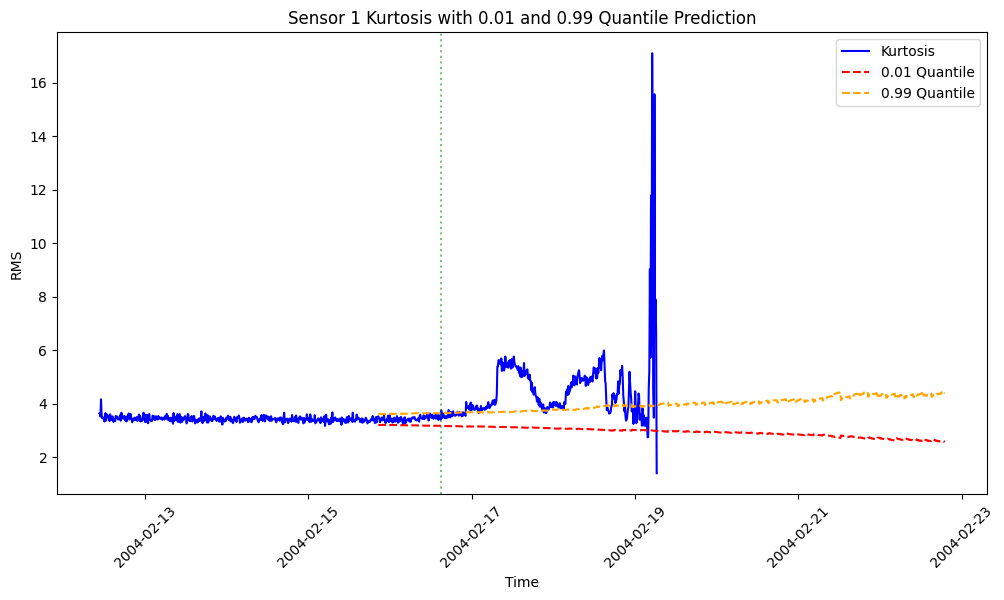

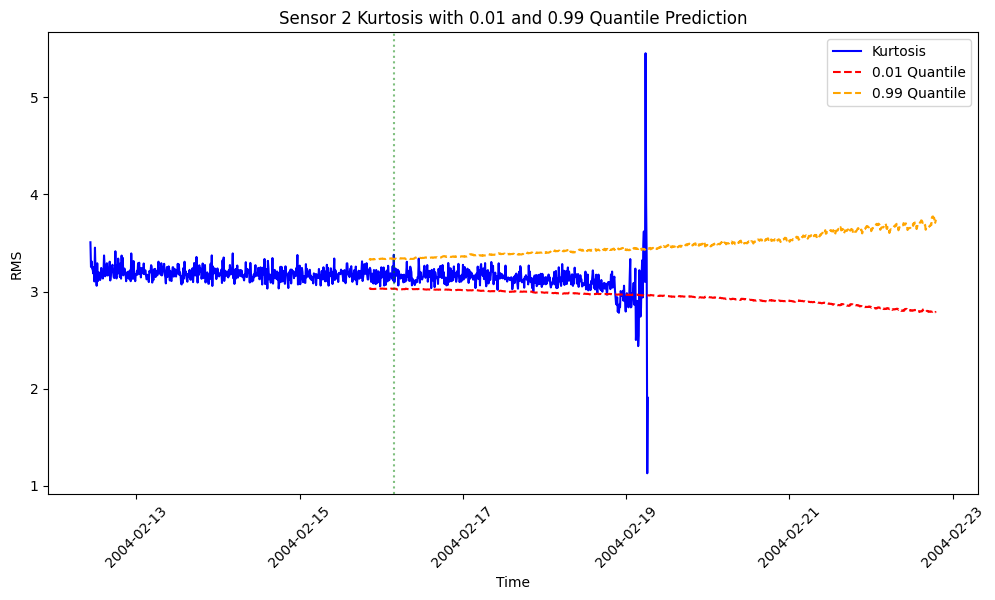

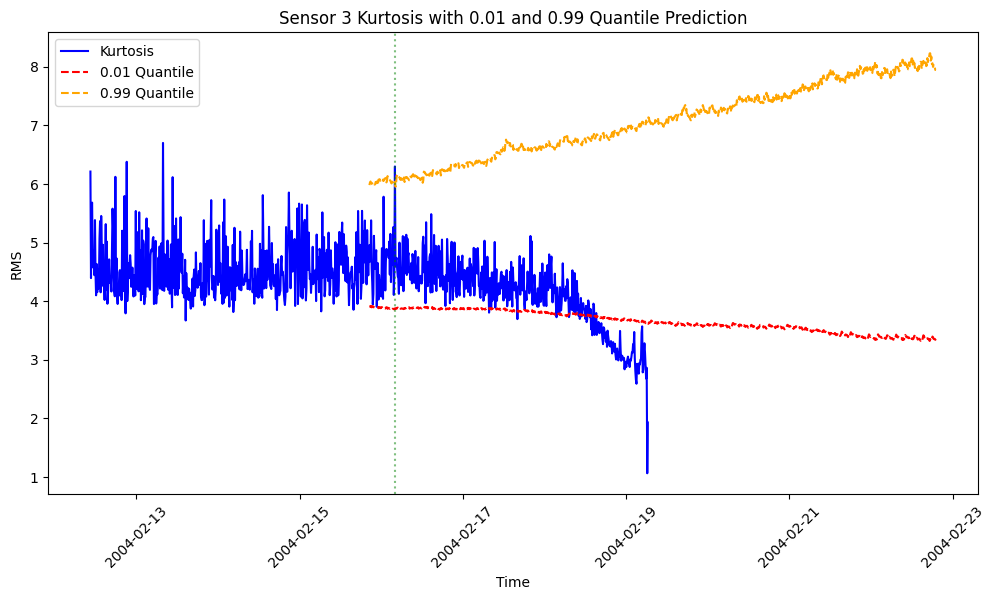

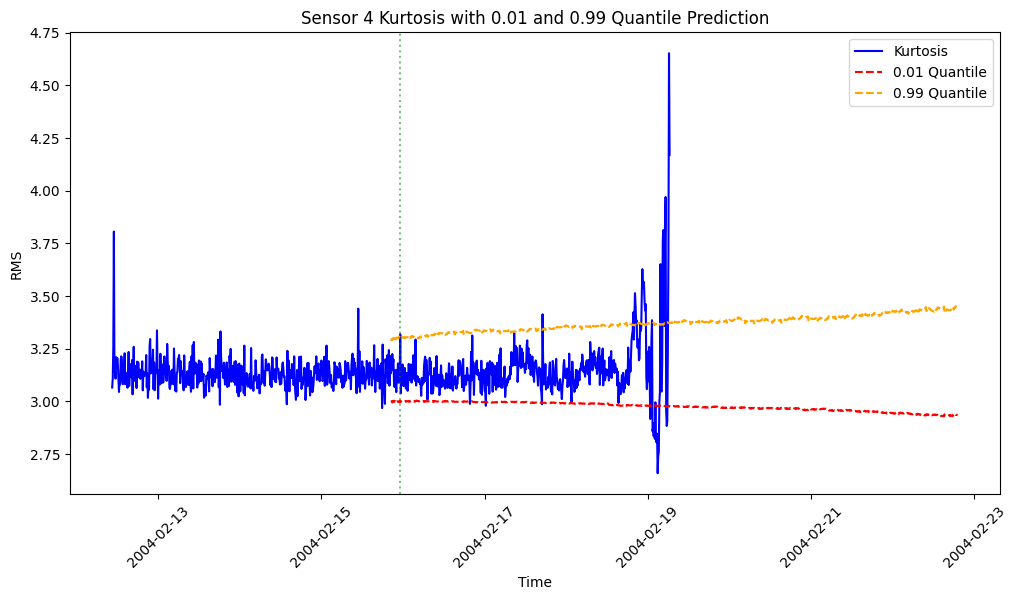

In [9]:
def pred_anomaly(sensor_id, feature='mahalanobis'): 
    sensor_data = getData_of_sensor(data, sensor_id)
    train = sensor_data[:sensor_data.shape[0]*50//100]
    #consider only the rms value flrom the graphs is the best feature to detect anomalies
    train = train[['timestamp', feature]].copy()
    train['item_id'] = [0]*train.shape[0]
    pred_df = pipeline.predict_df(train , prediction_length=1000, target=feature, quantile_levels=[0.01, 0.1, 0.5, 0.8,0.9, 0.99])
    

    plt.figure(figsize=(12,6))
    plt.title(f'Sensor {sensor_id+1} {feature.capitalize()} with 0.01 and 0.99 Quantile Prediction')
    plt.plot(sensor_data['timestamp'], sensor_data[feature], label=feature.capitalize(), color='blue')
    plt.plot(pred_df['timestamp'], pred_df['0.01'], label='0.01 Quantile', color='red', linestyle='--')
    plt.plot(pred_df['timestamp'], pred_df['0.99'], label='0.99 Quantile', color='orange', linestyle='--')
   
    for lower,upper,timestamp  in pred_df[['0.01', '0.99', 'timestamp']].values:
        actual_value = sensor_data.loc[sensor_data['timestamp'] == timestamp, feature].values[0]
        if actual_value < lower or actual_value > upper:
            plt.axvline(x=timestamp, color='green', linestyle=':', alpha=0.5)
            break
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('RMS')
    plt.xticks(rotation=45)
    


for sensor_id in range(4):
    pred_anomaly(sensor_id, feature='kurtosis')


non capisco perchè il bearing 3 è cosi ballerino anche se sano.

**predict_df** supports the following arguments:
- `df`: Long-format DataFrame with id, timestamp, and target column(s)
- `future_df`: Optional DataFrame with future covariates (columns present in both df and future_df are treated as known future covariates)
- `id_column`: Column with time series identifiers (default: "item_id")
- `timestamp_column`: Column with timestamps (default: "timestamp")
- `target`: Target column name(s) to forecast (default: "target")
- `prediction_length`: Number of steps to forecast
- `quantile_levels`: Quantiles to compute (default: [0.1, 0.2, ..., 0.9])

Returns a DataFrame with forecasts including point predictions and quantiles.

In [10]:
# PRED_LEN = 24
# INITIAL_DATA_POINTS = 100

# print(f"Using Chronos-2 with fine-tuning")
# print(f"Prediction length: {PRED_LEN}")
# print(f"Data shape: {data.shape}")

# # Prepara i dati per il fine-tuning
# # Chronos-2 richiede un tensor 3D: (n_series, n_variates, history_length)
# train_values = train['target'].values.astype(np.float32)
# train_tensor = torch.tensor(train_values).unsqueeze(0).unsqueeze(0)  # Shape: (1, 1, len(train))

# print(f"Train tensor shape: {train_tensor.shape}")

# # Fine-tune il modello
# try:
#     pipeline.fit(
#         inputs=train_tensor,
#         prediction_length=PRED_LEN,
#         num_steps=100,
#         batch_size=32,
#         learning_rate=1e-4
#     )
#     print("Fine-tuning completed successfully!")
# except Exception as e:
#     print(f"Fine-tuning error: {e}")
#     print("Continuing with pre-trained model...")

In [13]:
# pipeline.save_pretrained("chronos-2-finetuned-ims")

In [12]:
# print("number of indexes to process:", len(data)//INITIAL_DATA_POINTS)
# initial_fitted = 0
# for j in range(0,len(data),INITIAL_DATA_POINTS):
#     pred_df = pipeline.predict_df(data[j:j+INITIAL_DATA_POINTS], prediction_length=100, quantile_levels=[0.01, 0.1, 0.5, 0.8,0.9, 0.99])
    
#     results = []
#     min_trashold = "0.01"
#     max_trashold = "0.99"
#     #calculate the difference between the predicted and the real values
#     for i in range(len(pred_df)):
#         real_val = data.iloc[j + i]
#         predicted_val = pred_df.iloc[i]
        
#         #calculate the absolute error 
#         error = abs(predicted_val['predictions'] - real_val['target'])
        
        
        
#         if real_val['target'] < predicted_val[min_trashold] or real_val['target'] > predicted_val[max_trashold]:
#             results.append((error, 1))  # Anomaly
            
#             print(f"Anomaly detected at index {j//INITIAL_DATA_POINTS}-{i}, file idnex {i+j}, {real_val['timestamp']}: Real Value = {real_val['target']}, Predicted Interval = [{predicted_val[min_trashold]}, {predicted_val[max_trashold]}]")
#             break
#         else:
#             results.append((error, 0))  # Normal
        
#     initial_fitted = j       
#     #i get an error if the real value is outside the predicted quantiles

#     errors_df = pd.DataFrame(results, columns=['Absolute Error', 'is_anomaly'])
